In [2]:
obs

,orig.ident,nCount_Spatial,nFeature_Spatial,percent.mt
cell_id,,,,
AAACATCGAAACATCG-1,SeuratProject,2632,1727,2.887538
AAACATCGAACAACCA-1,SeuratProject,1522,1078,10.643890
AAACATCGAACCGAGA-1,SeuratProject,1952,1289,4.405738
AAACATCGAACGCTTA-1,SeuratProject,1047,755,11.461318
AAACATCGAACGTGAT-1,SeuratProject,3050,1916,2.196721
...,...,...,...,...
TTGCTGGAGAATCTGA-1,SeuratProject,2243,1529,11.279536
TTGCTGGAGACTAGTA-1,SeuratProject,1850,1306,10.216216
TTGCTGGAGAGCTGAA-1,SeuratProject,3546,2226,4.906937


In [5]:
logcounts.T

<4602x36601 sparse matrix of type '<class 'numpy.float64'>'
	with 4607262 stored elements in Compressed Sparse Column format>

In [21]:
# ---- PYTHON IMPORT & SAVE ----
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse, io as spio
import anndata as ad

base = "/Users/christoffer/work/karolinska/development/MitoMetaoMicS/data/dbit_MS/export_raw_l47"

# read matrices
counts = spio.mmread(f"{base}/counts.mtx").tocsr().T
logcounts = spio.mmread(f"{base}/logcounts.mtx").tocsr().T

# read names (must match orders used in R)
var_names = pd.read_csv(f"{base}/genes.tsv", header=None, sep="\t")[0].tolist()
obs_names = pd.read_csv(f"{base}/barcodes.tsv", header=None, sep="\t")[0].tolist()

# read tables
obs = pd.read_csv(f"{base}/obs.csv")
# ensure index matches obs_names order
obs = obs.set_index("cell_id").reindex(obs_names)
var = pd.read_csv(f"{base}/var.csv", index_col=0)

# build AnnData
adata = ad.AnnData(
    X = logcounts,
    obs = obs,
    var = var.loc[var_names]
)
adata.layers["counts"]    = counts
adata.layers["logcounts"] = logcounts  # keep explicitly too

# embeddings (if exported)
import os
for key in ["X_pca","X_umap","X_tsne"]:
    p = f"{base}/{key}.csv"
    if os.path.exists(p):
        emb = pd.read_csv(p, index_col=0)
        # align to obs_names
        emb = emb.reindex(adata.obs_names)
        adata.obsm[key] = emb.values

# spatial coords (if any)
for fn in os.listdir(base):
    if fn.startswith("spatial_") and fn.endswith(".csv"):
        coords = pd.read_csv(f"{base}/{fn}", index_col=0)
        coords = coords.reindex(adata.obs_names)
        adata.obsm["spatial"] = coords.values  # one spatial per object (adjust if multiple)



In [24]:
adata.obs

,orig.ident,nCount_Spatial,nFeature_Spatial,percent.mt
cell_id,,,,
AAACATCGAAACATCG-1,SeuratProject,2632,1727,2.887538
AAACATCGAACAACCA-1,SeuratProject,1522,1078,10.643890
AAACATCGAACCGAGA-1,SeuratProject,1952,1289,4.405738
AAACATCGAACGCTTA-1,SeuratProject,1047,755,11.461318
AAACATCGAACGTGAT-1,SeuratProject,3050,1916,2.196721
...,...,...,...,...
TTGCTGGAGAATCTGA-1,SeuratProject,2243,1529,11.279536
TTGCTGGAGACTAGTA-1,SeuratProject,1850,1306,10.216216
TTGCTGGAGAGCTGAA-1,SeuratProject,3546,2226,4.906937


In [61]:
genes = [
    "HIF1A",
    "NFE2L2",
    "AKT1",
    "PIK3CD",
    "HMOX1",
    "TXNIP",
    "SIRT2",
    "SLC16A1",
    "SLC16A3",
    "LDHA",
    "LDHB",
    "PKM",
    "MFN1",
    "MFN2",
    "OPA1",
    "PPARGC1A"
]

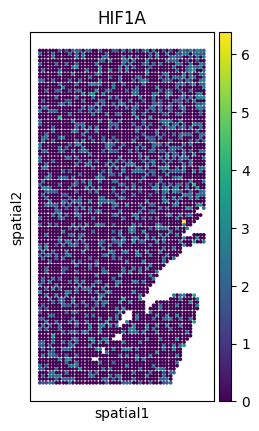

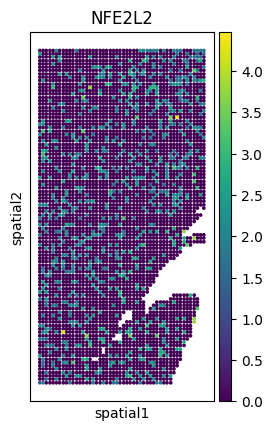

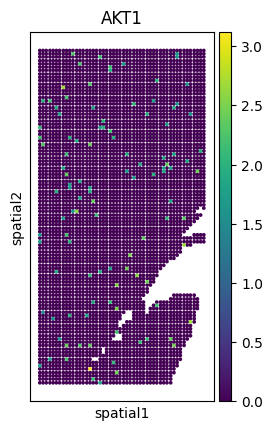

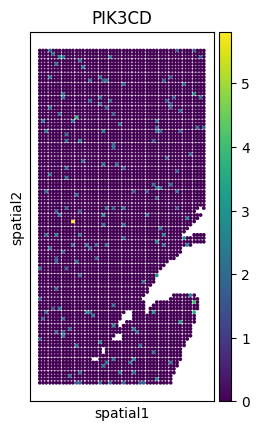

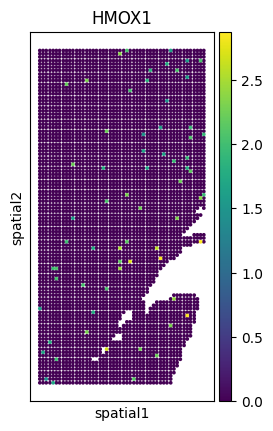

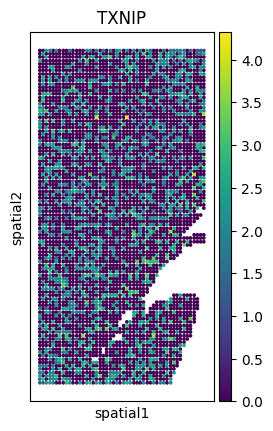

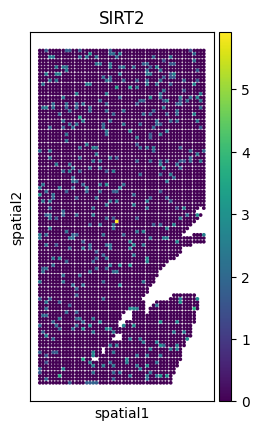

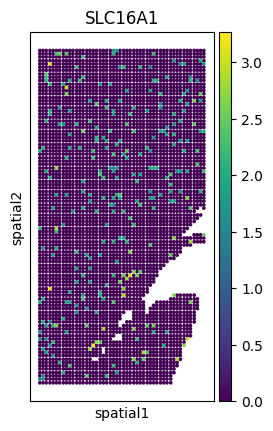

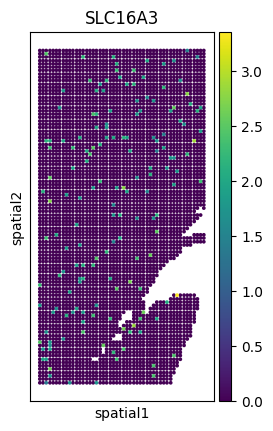

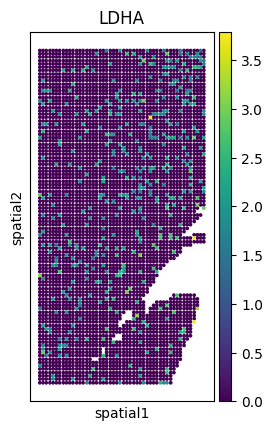

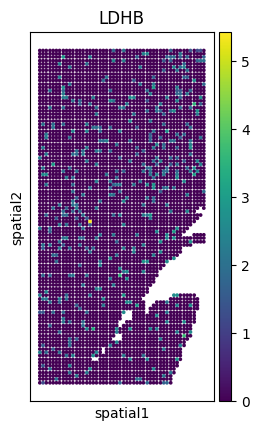

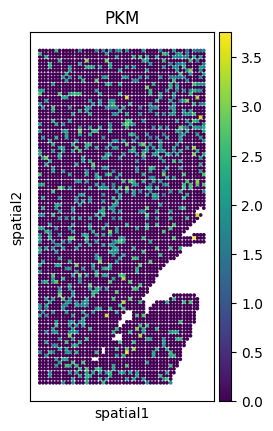

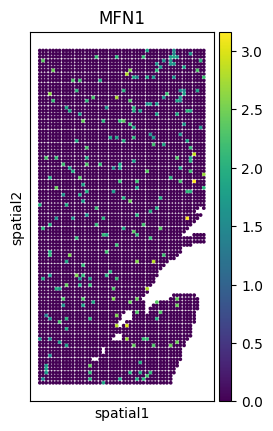

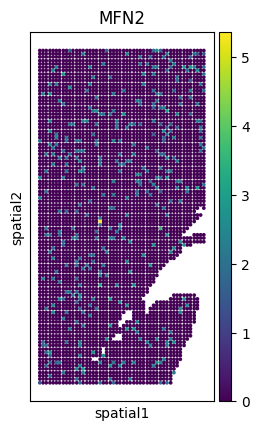

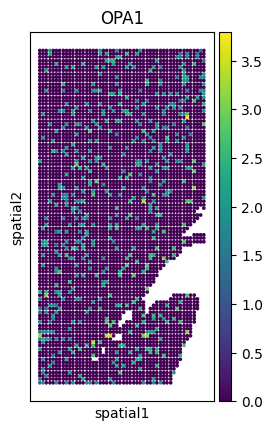

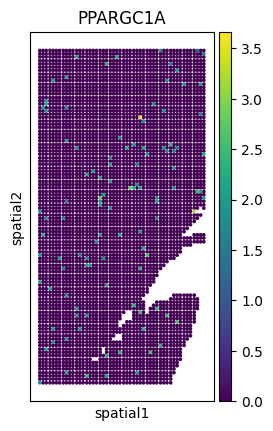

In [62]:
for gene in genes: 
    sc.pl.spatial(adata, color = gene, spot_size = 7)

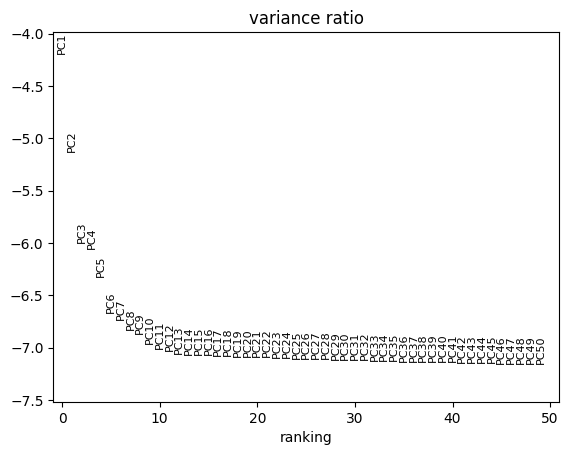

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [36]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

In [37]:
resolutions = [0.5, 1, 1.5 , 2, 2.5]
for resolution in resolutions: 
    print('clustering at resolution '+str(resolution))
    sc.tl.leiden(adata, resolution = resolution, key_added = 'leiden_'+str(resolution))
    print("done")

clustering at resolution 0.5
done
clustering at resolution 1
done
clustering at resolution 1.5
done
clustering at resolution 2
done
clustering at resolution 2.5
done


In [41]:
sc.tl.umap(adata, min_dist=0.1)

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


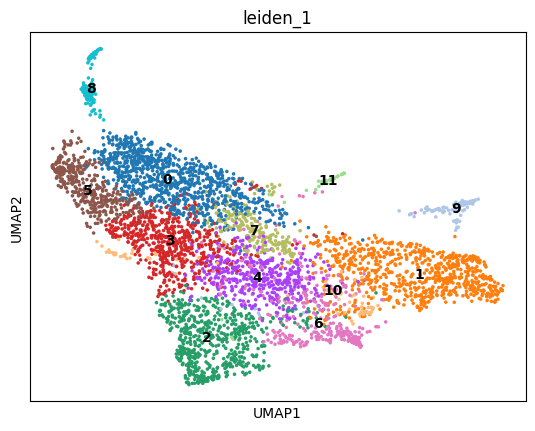

In [43]:
sc.pl.umap(adata, color = 'leiden_1', legend_loc = 'on data')

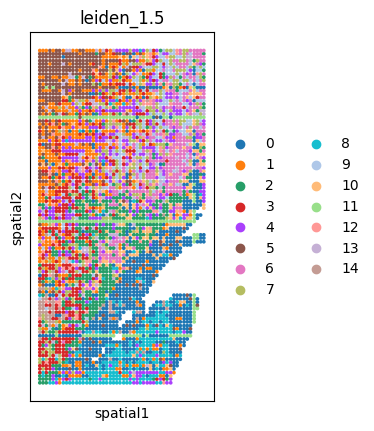

In [47]:
sc.pl.spatial(adata, color = 'leiden_1.5', spot_size = 7)

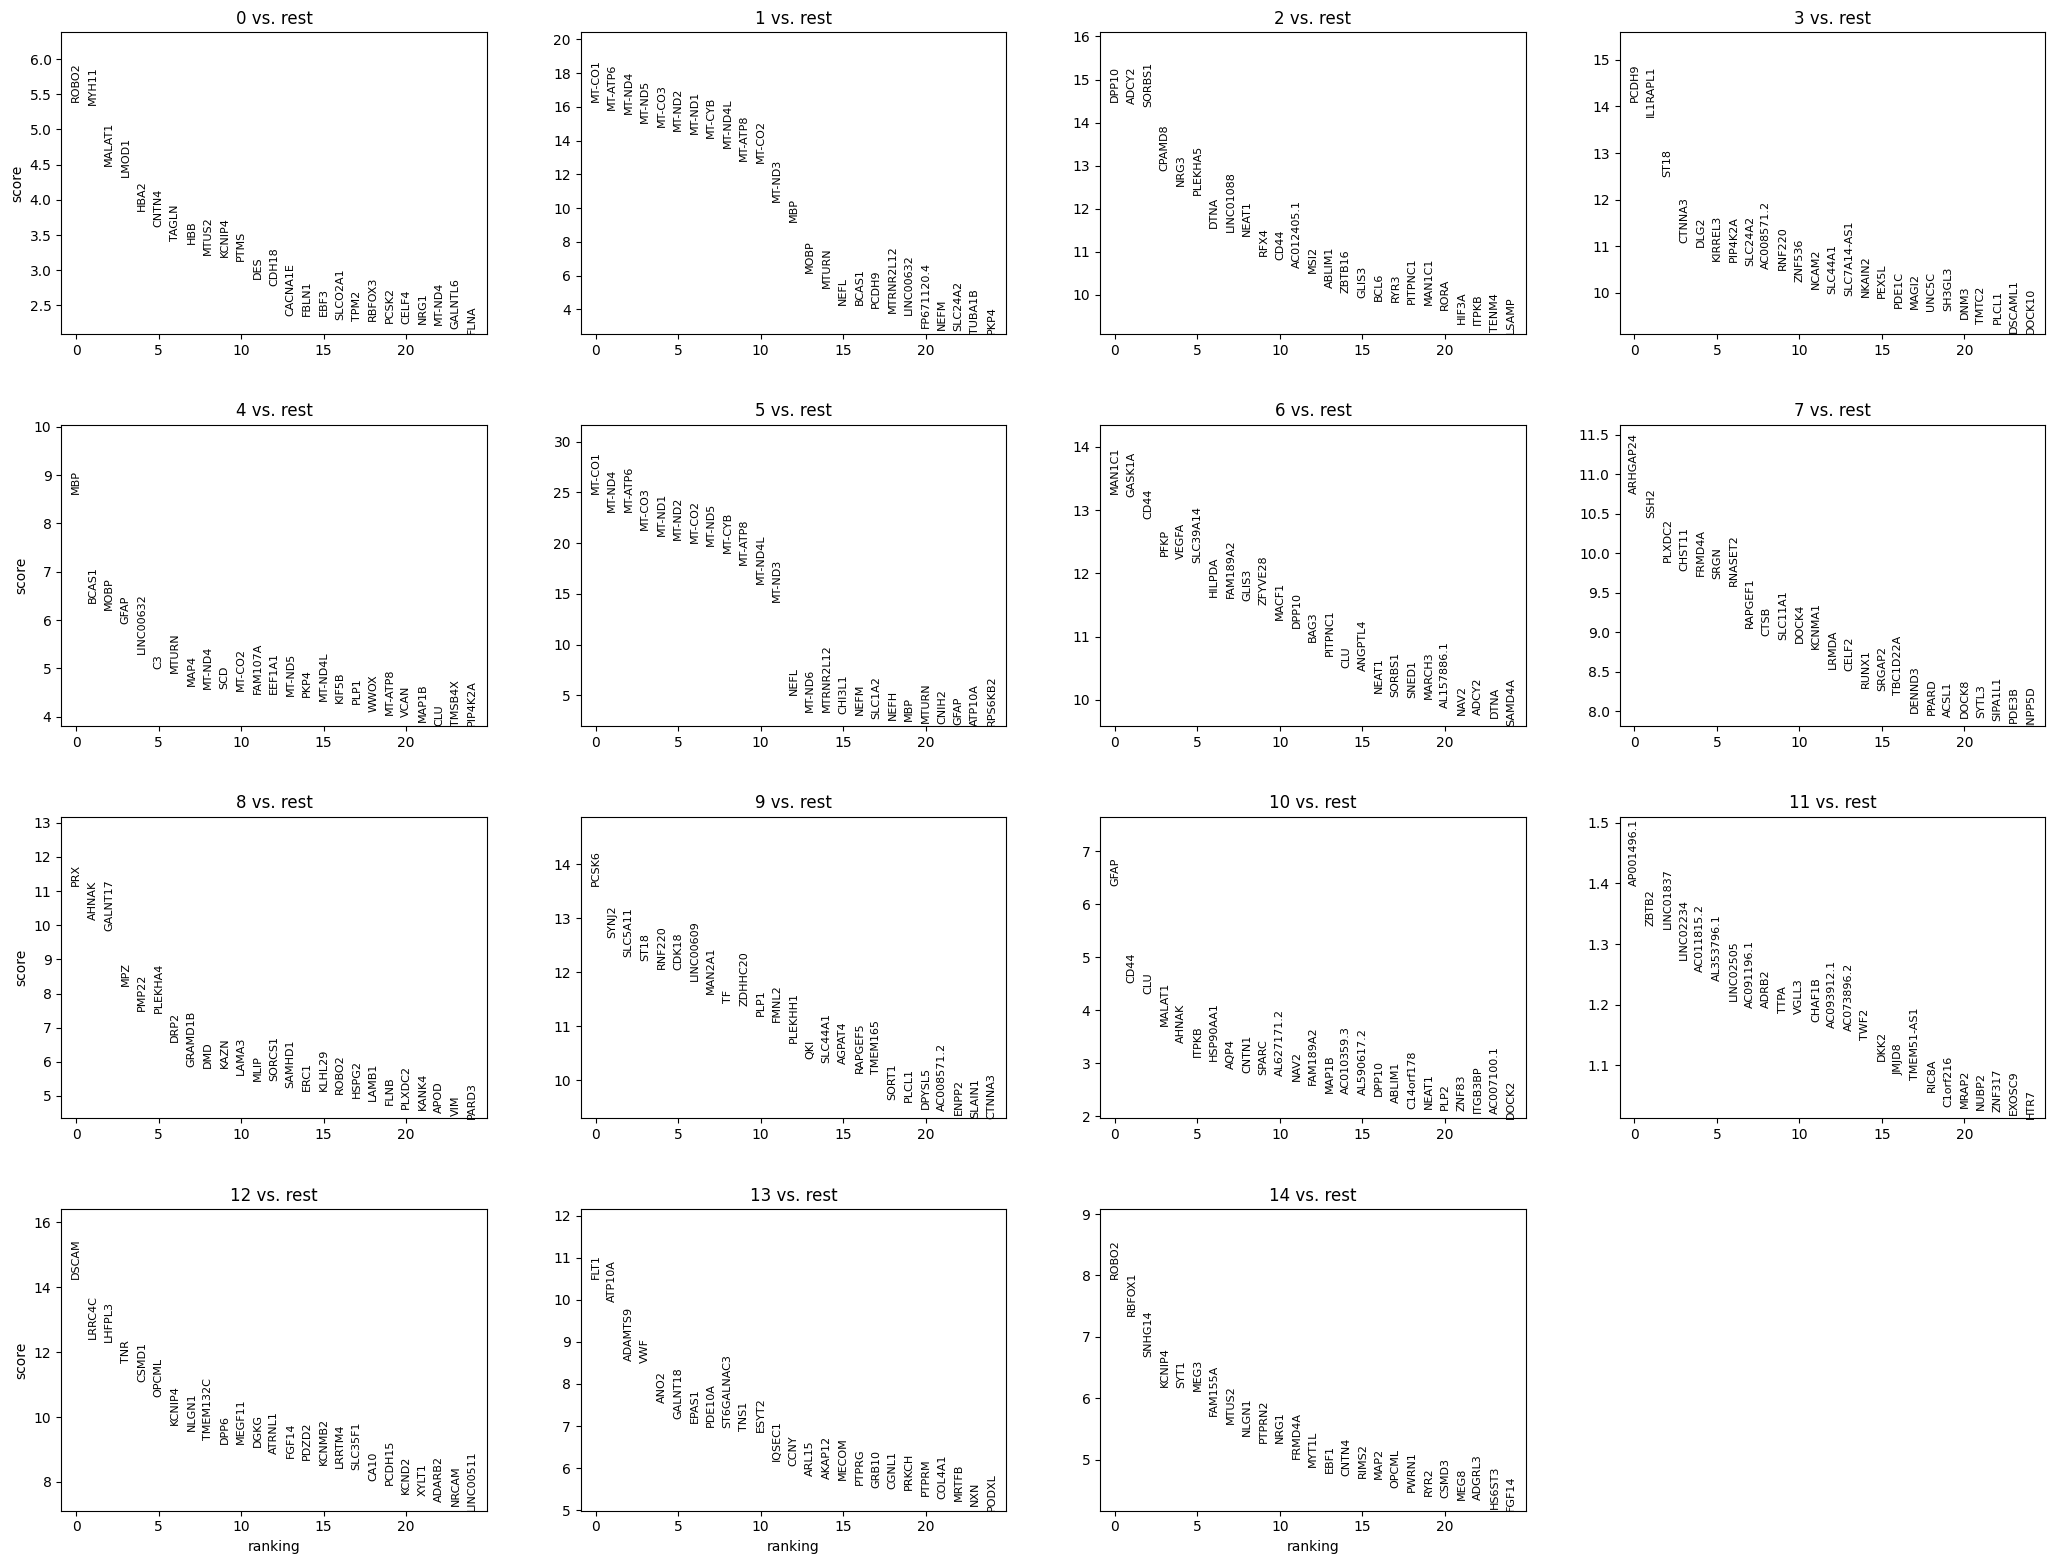

In [50]:
sc.tl.rank_genes_groups(adata, groupby='leiden_1.5', method='t-test_overestim_var')
# See top 5 marker genes per cluster
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [52]:
marker_genes = pd.DataFrame({
    group: adata.uns['rank_genes_groups']['names'][group][:20]
    for group in adata.uns['rank_genes_groups']['names'].dtype.names
})
marker_genes.head()
#marker_genes.to_csv('../data/broad_markers_leiden0-5.csv')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,ROBO2,MT-CO1,DPP10,PCDH9,MBP,MT-CO1,MAN1C1,ARHGAP24,PRX,PCSK6,GFAP,AP001496.1,DSCAM,FLT1,ROBO2
1,MYH11,MT-ATP6,ADCY2,IL1RAPL1,BCAS1,MT-ND4,GASK1A,SSH2,AHNAK,SYNJ2,CD44,ZBTB2,LRRC4C,ATP10A,RBFOX1
2,MALAT1,MT-ND4,SORBS1,ST18,MOBP,MT-ATP6,CD44,PLXDC2,GALNT17,SLC5A11,CLU,LINC01837,LHFPL3,ADAMTS9,SNHG14
3,LMOD1,MT-ND5,CPAMD8,CTNNA3,GFAP,MT-CO3,PFKP,CHST11,MPZ,ST18,MALAT1,LINC02234,TNR,VWF,KCNIP4
4,HBA2,MT-CO3,NRG3,DLG2,LINC00632,MT-ND1,VEGFA,FRMD4A,PMP22,RNF220,AHNAK,AC011815.2,CSMD1,ANO2,SYT1


In [53]:
for col in marker_genes.columns: 
    print(col)
    genes = marker_genes[col].tolist()
    print(" ".join(genes))
    print(' ')

0
ROBO2 MYH11 MALAT1 LMOD1 HBA2 CNTN4 TAGLN HBB MTUS2 KCNIP4 PTMS DES CDH18 CACNA1E FBLN1 EBF3 SLCO2A1 TPM2 RBFOX3 PCSK2
 
1
MT-CO1 MT-ATP6 MT-ND4 MT-ND5 MT-CO3 MT-ND2 MT-ND1 MT-CYB MT-ND4L MT-ATP8 MT-CO2 MT-ND3 MBP MOBP MTURN NEFL BCAS1 PCDH9 MTRNR2L12 LINC00632
 
2
DPP10 ADCY2 SORBS1 CPAMD8 NRG3 PLEKHA5 DTNA LINC01088 NEAT1 RFX4 CD44 AC012405.1 MSI2 ABLIM1 ZBTB16 GLIS3 BCL6 RYR3 PITPNC1 MAN1C1
 
3
PCDH9 IL1RAPL1 ST18 CTNNA3 DLG2 KIRREL3 PIP4K2A SLC24A2 AC008571.2 RNF220 ZNF536 NCAM2 SLC44A1 SLC7A14-AS1 NKAIN2 PEX5L PDE1C MAGI2 UNC5C SH3GL3
 
4
MBP BCAS1 MOBP GFAP LINC00632 C3 MTURN MAP4 MT-ND4 SCD MT-CO2 FAM107A EEF1A1 MT-ND5 PKP4 MT-ND4L KIF5B PLP1 WWOX MT-ATP8
 
5
MT-CO1 MT-ND4 MT-ATP6 MT-CO3 MT-ND1 MT-ND2 MT-CO2 MT-ND5 MT-CYB MT-ATP8 MT-ND4L MT-ND3 NEFL MT-ND6 MTRNR2L12 CHI3L1 NEFM SLC1A2 NEFH MBP
 
6
MAN1C1 GASK1A CD44 PFKP VEGFA SLC39A14 HILPDA FAM189A2 GLIS3 ZFYVE28 MACF1 DPP10 BAG3 PITPNC1 CLU ANGPTL4 NEAT1 SORBS1 SNED1 MARCH3
 
7
ARHGAP24 SSH2 PLXDC2 CHST11 FRMD4A SRGN RNASET

In [54]:
cluster_annotations = {
    0: "Vascularture",
    1: "Oligodendrocytes I",
    2: "Neurons I",
    3: "Neurons II",
    4: "Oligodendrocytes II",
    5: "Neurons III",
    6: "Reactive astrocytes",
    7: "Activated myeloid",
    8: "Schwann",
    9: "Oligodendrocytes III",
    10: "Astrocytes",
    11: "Unknown",
    12: "Neurons IV",
    13: "Endothelial cells",
    14: "Neurons V"
}

In [55]:
adata.obs["celltype_annotation"] = adata.obs["leiden_1.5"].astype(int).map(cluster_annotations)

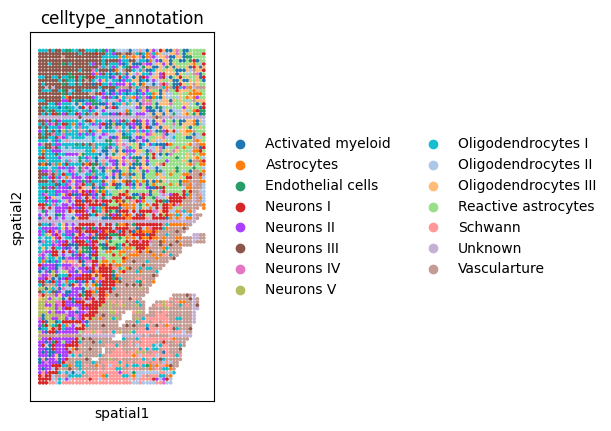

In [57]:
sc.pl.spatial(adata, color = 'celltype_annotation', spot_size = 7)

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


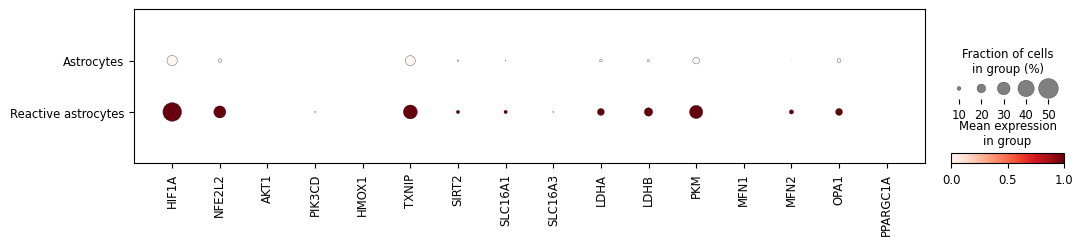

In [63]:
dp = sc.pl.dotplot(
    adata[adata.obs.celltype_annotation.str.contains('str')],
    var_names=genes,
    groupby="celltype_annotation",
    standard_scale="var",
    dot_max=0.5, dot_min=0.05, color_map="Reds",
    dendrogram=False,
    figsize=(12, 2),
    #vmin=-5,
    vmax=1,
    #categories_order = ordered_cell_types,
)
#dp.savefig("../../data/plots/bioenergetic_map_Chronic.svg", bbox_inches="tight")